In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt


In [2]:
# Parameters
beta = 0.96  # Discount factor
sigma = 2    # Intertemporal elasticity of substitution
phi = 1      # Labor supply elasticity
alpha = 0.36 # Capital share in production
delta = 0.05 # Depreciation rate
gamma = 0.1  # Sensitivity of default to carbon tax
theta_climate = 0.05  # Bank's climate risk sensitivity
rho = 0.9    # Persistence of climate policy shocks

# Climate policy parameters
tau_carbon_initial = 0.05  # Initial carbon tax
policy_shock_variance = 0.01


In [5]:
# Utility function
def utility(consumption, labor, sigma, phi):
    return (consumption ** (1 - sigma)) / (1 - sigma) - (labor ** (1 + phi)) / (1 + phi)

# Production function
def production(capital, labor, A_t, alpha):
    return A_t * (capital ** alpha) * (labor ** (1 - alpha))

# Capital accumulation equation
def capital_accumulation(capital, investment, delta):
    return (1 - delta) * capital + investment

# Loan rate considering climate transition risk
def loan_rate_f(base_rate, tau_carbon, theta_climate):
    return base_rate + theta_climate * tau_carbon

# Probability of default due to climate risk
def default_probability(tau_carbon, gamma, shock):
    return gamma * tau_carbon + shock


In [6]:
# Solving the dynamic system of equations
def dsge_system(vars, params):
    consumption, labor, capital, investment, loan_rate, default_rate, tau_carbon = vars
    beta, sigma, phi, alpha, delta, gamma, theta_climate, rho, A_t = params
    
    # Equations for the system
    eq1 = consumption + investment - production(capital, labor, A_t, alpha)  # Goods market clearing
    eq2 = consumption ** (-sigma) - beta * (consumption ** (-sigma)) * (1 + loan_rate)  # Euler equation
    eq3 = labor - labor  # Labor market clearing (trivial in this example)
    eq4 = capital_accumulation(capital, investment, delta) - capital  # Capital accumulation
    eq5 = loan_rate - loan_rate_f(loan_rate, tau_carbon, theta_climate)  # Loan rate dynamics
    eq6 = default_rate - default_probability(tau_carbon, gamma, 0)  # Default rate dynamics
    eq7 = tau_carbon - (rho * tau_carbon + (1 - rho) * tau_carbon_initial)  # Climate policy equation

    return [eq1, eq2, eq3, eq4, eq5, eq6, eq7]

# Parameters for the system
params = [beta, sigma, phi, alpha, delta, gamma, theta_climate, rho, 1.0]

# Initial values (guess for the solver)
initial_guess = [0.5, 0.5, 0.5, 0.1, 0.05, 0.01, tau_carbon_initial]

# Solve the system
solution = fsolve(dsge_system, initial_guess, args=(params,))


C:\Users\phata\AppData\Local\Temp\ipykernel_9512\3458012018.py:7: RuntimeWarning: invalid value encountered in scalar power
  return A_t * (capital ** alpha) * (labor ** (1 - alpha))
C:\Users\phata\AppData\Local\Temp\ipykernel_9512\1331877545.py:24: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(dsge_system, initial_guess, args=(params,))


C:\Users\phata\AppData\Local\Temp\ipykernel_9512\3458012018.py:7: RuntimeWarning: invalid value encountered in scalar power
  return A_t * (capital ** alpha) * (labor ** (1 - alpha))
C:\Users\phata\AppData\Local\Temp\ipykernel_9512\2486238900.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(dsge_system, solution, args=(params,))


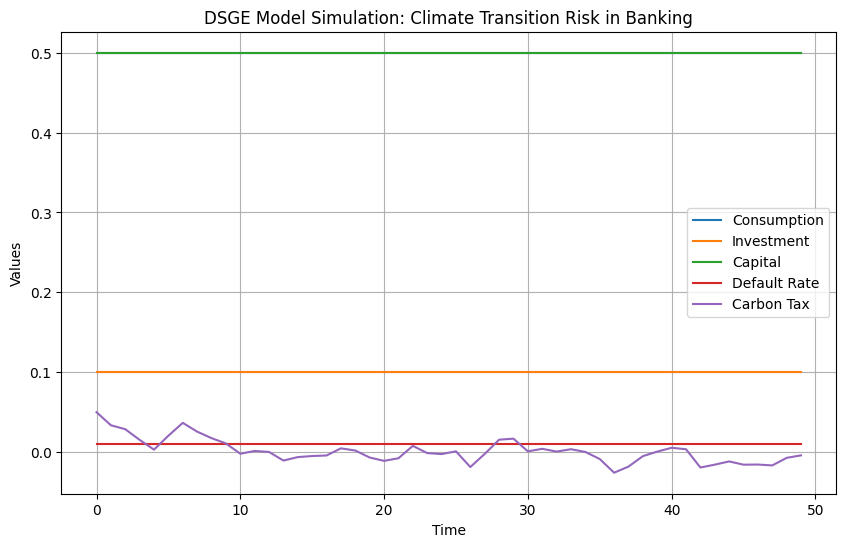

In [7]:
# Time horizon
T = 50
consumption_path = np.zeros(T)
investment_path = np.zeros(T)
capital_path = np.zeros(T)
tau_carbon_path = np.zeros(T)
default_rate_path = np.zeros(T)

# Initialize values
consumption_path[0] = solution[0]
investment_path[0] = solution[3]
capital_path[0] = solution[2]
tau_carbon_path[0] = solution[6]
default_rate_path[0] = solution[5]

# Simulate over time
for t in range(1, T):
    # Climate policy shock (stochastic component)
    policy_shock = np.random.normal(0, policy_shock_variance)
    tau_carbon_path[t] = rho * tau_carbon_path[t-1] + policy_shock
    
    # Solve the system at each time step
    solution = fsolve(dsge_system, solution, args=(params,))
    
    # Store the results
    consumption_path[t] = solution[0]
    investment_path[t] = solution[3]
    capital_path[t] = solution[2]
    default_rate_path[t] = solution[5]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(consumption_path, label='Consumption')
plt.plot(investment_path, label='Investment')
plt.plot(capital_path, label='Capital')
plt.plot(default_rate_path, label='Default Rate')
plt.plot(tau_carbon_path, label='Carbon Tax')
plt.legend()
plt.title('DSGE Model Simulation: Climate Transition Risk in Banking')
plt.xlabel('Time')
plt.ylabel('Values')
plt.grid(True)
plt.show()
